In [1]:
from pathlib import Path
from datetime import datetime
import random
import torch
import torch.nn as nn
from torch.nn.utils.rnn import pad_sequence, unpad_sequence, pack_sequence, pad_packed_sequence
from torchmetrics.classification import BinaryF1Score
from tqdm.auto import tqdm
import wandb

torch.set_printoptions(sci_mode=False)
RANDOM_SEED = 1
DEV = 'cuda' if torch.cuda.is_available() else 'cpu'

In [2]:
class OsuDataset:
    """
    Beatmap + audio dataset.
    GETITEM: specs, beat_phase, beat_num, difficulty, onsets, actions
    """

    def __init__(self, beatmap_path, audio_path):
        self.beatmap_fns = sorted(list(beatmap_path.glob('*.pt')))
        self.audio_fns = sorted(list(audio_path.glob('*.pt')))
        print('Loading dataset...', end='')
        self.beatmap_stems = [fn.stem.split('-')[0] for fn in self.beatmap_fns]
        self.beatmaps = [torch.load(fn) for fn in self.beatmap_fns]
        self.audio_stems = [fn.stem for fn in self.audio_fns]
        self.audio = [torch.load(fn) for fn in self.audio_fns]
        print('Done')

    def __len__(self):
        return len(self.beatmaps)

    def __getitem__(self, idx):
        try:
            audio_idx = self.audio_stems.index(self.beatmap_stems[idx])
        except ValueError:
            raise FileNotFoundError(f'Audio file not found for {self.beatmap_stems[idx]}')
            
        actions, onsets, _, difficulty = self.beatmaps[idx].values()
        specs, beat_phase, beat_num = self.audio[audio_idx].values()

        # randomly slice data to 30s
        if specs.shape[1] > 3001:
            start = random.randint(0, specs.shape[1] - 3001)
            actions = actions[start:start+3001]
            onsets = onsets[start+1:start+3001]
            specs = specs[:, start+1:start+3001, :]
            beat_phase = beat_phase[start+1:start+3001]
            beat_num = beat_num[start+1:start+3001]
            difficulty = (torch.FloatTensor([difficulty]) * 0.2).expand(3000).unsqueeze(-1)
        else:
            raise IndexError(f'Beatmap shorter than 30s: {self.beatmap_stems[idx]}')

        return specs, beat_phase, beat_num, difficulty, onsets, actions

In [8]:
class PadCollater:
    # def __init__(self):
    #     self.hyperparam = 0
    def __call__(self, batch):
        specs = []
        beat_phases = []
        beat_nums = []
        difficulties = []
        onsets = []
        actions = []

        for x in batch:
            specs.append(x[0])
            beat_phases.append(x[1])
            beat_nums.append(x[2])
            difficulties.append(x[3])
            onsets.append(x[4])
            actions.append(x[5])

        specs = torch.stack(specs)
        beat_phases = torch.stack(beat_phases)
        beat_nums = torch.stack(beat_nums)
        difficulties = torch.stack(difficulties)
        onsets = torch.stack(onsets)
        actions = torch.stack(actions)

        return specs, beat_phases, beat_nums, difficulties, onsets, actions

### Model

In [3]:
class StackModel(nn.Module):
    def __init__(self, bp_emb_dim=16, bn_emb_dim=8, diff_emb_dim=8,
                 np_hidden_size=256, np_num_layers=2, ns_pre_proj_size=32,
                 ns_hidden_size=256, ns_num_layers=2,
                 num_tokens=256, action_emb_dim=32): # __init__(self, net_param)
        super().__init__()
        self.gelu = nn.GELU()
        self.sigmoid = nn.Sigmoid()
        self.stack = nn.Sequential(
            nn.Conv2d(3, 8, (5, 3), stride=(1, 2), padding=(2, 1)),
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.Conv2d(8, 16, (5, 3), stride=(1, 2), padding=(2, 1)),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(16, 32, (5, 3), stride=(1, 2), padding=(2, 1)),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, (5, 3), stride=(1, 2), padding=(2, 1)),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        self.beat_phase_emb = nn.Embedding(49, bp_emb_dim)
        self.beat_num_emb = nn.Embedding(4, bn_emb_dim)
        self.difficulty_proj = nn.Sequential(
            nn.Linear(1, diff_emb_dim),
            nn.ReLU(),
            nn.Linear(diff_emb_dim, diff_emb_dim),
            nn.ReLU()
        )
        self.action_emb = nn.Embedding(num_tokens, action_emb_dim)

        self.np_gru = nn.GRU(input_size=320 + bp_emb_dim + bn_emb_dim + diff_emb_dim,
                             hidden_size=np_hidden_size,
                             num_layers=np_num_layers,
                             batch_first=True,
                             bidirectional=True)
        self.np_proj_1 = nn.Linear(np_hidden_size*2, 128)
        self.np_proj_2 = nn.Linear(128, 1)

        self.ns_pre_proj = nn.Linear(128, ns_pre_proj_size)
        self.ns_gru = nn.GRU(input_size=320 + ns_pre_proj_size + bp_emb_dim + bn_emb_dim + diff_emb_dim + action_emb_dim,
                             hidden_size=ns_hidden_size,
                             num_layers=ns_num_layers,
                             batch_first=True,
                             bidirectional=False)
        self.ns_proj_1 = nn.Linear(ns_hidden_size, ns_hidden_size)
        self.ns_proj_2 = nn.Linear(ns_hidden_size, num_tokens)

    def forward(self, specs, beat_phases, beat_nums, difficulties, actions):
        conv_outs = self.stack(specs)
        conv_outs = conv_outs.permute(0, 2, 1, 3).reshape(conv_outs.shape[0], conv_outs.shape[2], -1)
        bp_emb = self.beat_phase_emb(beat_phases)
        bn_emb = self.beat_num_emb(beat_nums)
        diff_proj = self.difficulty_proj(difficulties)

        # ========== Note Placement ========== #
        np_in = torch.cat([conv_outs, bp_emb, bn_emb, diff_proj], dim=-1)
        np_out, last_hidden = self.np_gru(np_in)

        np_proj_1_out = self.gelu(self.np_proj_1(np_out))
        np_pred = self.sigmoid(self.np_proj_2(np_proj_1_out)).squeeze()

        # ========== Note Selection ========== #
        ns_pre_proj = self.gelu(self.ns_pre_proj(np_proj_1_out))
        if actions is not None: # teacher-force training
          action_emb = self.action_emb(actions)
          ns_in = torch.cat(
              [conv_outs, ns_pre_proj, bp_emb, bn_emb, diff_proj, action_emb], dim=-1)
          ns_out, ns_last_hidden = self.ns_gru(ns_in)

          ns_proj_1_out = self.gelu(self.ns_proj_1(ns_out))
          ns_logit = self.ns_proj_2(ns_proj_1_out)
        else:
          pass  

        return np_pred, ns_logit, ns_last_hidden

### Inference

In [4]:
# model, wav_path, difficulty_float


# model + pre-processed_inputs 
def infer(model, specs, beat_phases, beat_nums, difficulties, device):
    specs = specs.to(device)
    beat_phases = beat_phases.to(device)
    beat_nums = beat_nums.to(device)
    difficulties = difficulties.to(device)

    model.eval()
    with torch.inference_mode():
        conv_outs = model.stack(specs)
        conv_outs = conv_outs.permute(0, 2, 1, 3).flatten(2,3)
        bp_emb = model.beat_phase_emb(beat_phases)
        bn_emb = model.beat_num_emb(beat_nums)
        diff_proj = model.difficulty_proj(difficulties)

        np_in = torch.cat([conv_outs, bp_emb, bn_emb, diff_proj], dim=-1)
        np_out, _ = model.np_gru(np_in)
        np_proj_1_out = model.gelu(model.np_proj_1(np_out))
        ns_pre_proj = model.gelu(model.ns_pre_proj(np_proj_1_out))
        
        out = torch.zeros([specs.shape[0], specs.shape[2]], device=device)
        action_emb = model.action_emb(torch.zeros([specs.shape[0], 1], device=device, dtype=torch.long))
        last_hidden = torch.zeros([2, specs.shape[0], 256], device=device)

        ns_in = torch.cat([conv_outs, ns_pre_proj, bp_emb, bn_emb, diff_proj], dim=-1)
        for i in range(specs.shape[2]):
            ns_in_temp = torch.cat([ns_in[:, i:i+1], action_emb], -1) # N x 1 x C
            ns_out, last_hidden = model.ns_gru(ns_in_temp, last_hidden)
            ns_proj_1_out = model.gelu(model.ns_proj_1(ns_out))
            ns_logit = model.ns_proj_2(ns_proj_1_out)
            ns_pred = ns_logit.argmax(dim=-1)
            out[:, i] = ns_pred
            action_emb = model.action_emb(ns_pred)

    return out

In [5]:
from utils import index_to_combination

beatmap = []
for i, token in enumerate(out):
    if token.item() > 0:
        key0, key1, key2, key3 = index_to_combination(token.item(), 4)
        beatmap.append([i * 10, key0, key1, key2, key3])

beatmap_str_list = []
long = [False, False, False, False]
long_start = [[], [], [], []]
long_end = [[], [], [], []]
line_num = 0
for timestep_idx, action in enumerate(beatmap):
    time = action[0]
    keys = action[1:]
    for key, token in enumerate(keys):
        if token > 0:
            xpos = 64 + key * 128
            if token == 2:
                print(f'{key} long note start')
                long_start[key].append(line_num)
                beatmap_str_list.append(f'{xpos},192,{time},128,2,')
                long[key] = True
            elif token == 3 and long[key] == True:
                print(f'{key} long note end')
                long_end[key].append(time)
                long[key] = False
                break
            else:
                beatmap_str_list.append(f'{xpos},192,{time},1,0,0:0:0:0:')
            line_num += 1

for start_key, l in enumerate(long_start):
    for i, line_num in enumerate(l):
        endtime = long_end[start_key][i]
        beatmap_str_list[line_num] = f'{beatmap_str_list[line_num]}{endtime}:0:0:0:0:'

NameError: name 'out' is not defined

In [ ]:
file = open(Path('osu_dataset/test/inference.txt'), 'w')
file.write('\n'.join(beatmap_str_list))
file.close()

### Train

In [6]:
class Trainer():
    def __init__(self, model, optimizer, train_loader,
                 valid_loader, device, checkpoint_path: Path,
                 np_fl_gamma=2, np_fl_weight=0.8,
                 ns_fl_gamma=2, ns_fl_weight=0.8,
                 np_loss_multiplier=7):
        self.model = model
        self.optimizer = optimizer
        self.train_loader = train_loader
        self.valid_loader = valid_loader
        self.device = device
        self.checkpoint_path = checkpoint_path
        checkpoint_path.mkdir(exist_ok=True)
        self.np_fl_gamma = np_fl_gamma
        self.np_fl_weight = np_fl_weight
        self.ns_fl_gamma = ns_fl_gamma
        self.ns_fl_weight = ns_fl_weight
        self.np_loss_multiplier = np_loss_multiplier
        self.start_epoch = 0
        self.f1 = BinaryF1Score().to(self.device)
        # TODO: metrics (Perplexity, F-score, AUC...)

    def load_checkpoint(self, fn):
        checkpoint = torch.load(fn, map_location=self.device)
        self.start_epoch = checkpoint['epoch'] + 1
        self.model.load_state_dict(checkpoint['model_state_dict'])
        self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        for state in self.optimizer.state.values():
            for k, v in state.items():
                if (torch.is_tensor(v)):
                    state[k] = v.to(self.device)

    def save_checkpoint(self, epoch, fn):
        checkpoint = {
            'epoch': epoch,
            'model_state_dict': self.model.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict()
        }
        torch.save(checkpoint, fn)

    def binary_focal_loss(self, y, pred, gamma, pos_weight):
        """
        Biary focal loss for when y=1 is the minority class.\n
        INPUT
            gamma: factor for suppressing loss for easy examples (gamma > 1)
            pos_weight: how much to suppress loss when y=0 (0 <= pos_weight <= 1)
        """
        return -(y * (1-pred).pow(gamma) * pred.log() +
                 pos_weight * (1-y) * pred.pow(gamma) * (1-pred).log()).mean()

    def multi_focal_loss(self, y, pred, gamma, pos_weight):
        """
        Multi-class focal loss for when y=0 is the majority class.\n
        INPUT
            gamma: factor for suppressing loss for easy examples (gamma > 1)
            pos_weight: how much to suppress loss when y=0 (0 <= pos_weight <= 1)
        """
        p_y = pred[torch.arange(len(pred)), y]
        weight_mask = torch.where(y == 0, pos_weight, 1)
        return -(weight_mask * (1 - p_y).pow(gamma) * p_y.log()).mean()

    def train(self, num_epochs, log_to_wandb=True, hyperparams=None):
        if log_to_wandb:
            wandb.init(project='AutoOsu', config=hyperparams)
            
        self.model.to(self.device)
        for epoch in tqdm(range(self.start_epoch, num_epochs)):
            self.model.train()
            for batch in tqdm(self.train_loader, leave=False):
                specs, beat_phases, beat_nums, difficulties, onsets, actions = batch
                specs = specs.to(self.device)
                beat_phases = beat_phases.to(self.device)
                beat_nums = beat_nums.to(self.device)
                difficulties = difficulties.to(self.device)
                onsets = onsets.to(self.device)
                actions_gt = actions[:, 1:].to(self.device)
                actions_shifted = actions[:, :-1].to(self.device)

                np_pred, ns_logit, _ = self.model(
                    specs, beat_phases, beat_nums, difficulties, actions_shifted)

                np_pred = torch.reshape(np_pred, [-1])
                np_label = torch.reshape(onsets, [-1])

                ns_pred = torch.reshape(
                    ns_logit, [-1, ns_logit.shape[-1]]).softmax(dim=-1)
                ns_label = torch.reshape(actions_gt, [-1])

                np_loss = self.binary_focal_loss(
                    np_label, np_pred, self.np_fl_gamma, self.np_fl_weight) 
                ns_loss = self.multi_focal_loss(
                    ns_label, ns_pred, self.ns_fl_gamma, self.ns_fl_weight)

                batch_loss = np_loss * self.np_loss_multiplier + ns_loss
                self.optimizer.zero_grad()
                batch_loss.backward()
                self.optimizer.step()

                ns_acc = (ns_pred.argmax(dim=-1) == ns_label).float().mean()
                if log_to_wandb:
                    wandb.log({'train_np_loss': np_loss.item(),
                            'train_ns_loss': ns_loss.item(),
                            'train_loss': batch_loss.item(),
                            'train_acc': ns_acc.item(),
                            'train_np_f1': self.f1(np_pred, np_label.int()).item()})

            self.model.eval()
            with torch.inference_mode():
                valid_np_loss_sum = 0
                valid_ns_loss_sum = 0
                valid_loss_sum = 0
                valid_np_f1_sum = 0
                valid_ns_acc_sum = 0
                for batch in tqdm(self.valid_loader, leave=False):
                    specs, beat_phases, beat_nums, difficulties, onsets, actions = batch
                    specs = specs.to(self.device)
                    beat_phases = beat_phases.to(self.device)
                    beat_nums = beat_nums.to(self.device)
                    difficulties = difficulties.to(self.device)
                    onsets = onsets.to(self.device)
                    actions_gt = actions[:, 1:].to(self.device)
                    actions_shifted = actions[:, :-1].to(self.device)

                    np_pred, ns_logit, _ = self.model(
                        specs, beat_phases, beat_nums, difficulties, actions_shifted)

                    np_pred = torch.reshape(np_pred, [-1])
                    np_label = torch.reshape(onsets, [-1])

                    ns_pred = torch.reshape(
                        ns_logit, [-1, ns_logit.shape[-1]]).softmax(dim=-1)
                    ns_label = torch.reshape(actions_gt, [-1])

                    np_loss = self.binary_focal_loss(
                        np_label, np_pred, self.np_fl_gamma, self.np_fl_weight) * self.np_loss_multiplier
                    ns_loss = self.multi_focal_loss(
                        ns_label, ns_pred, self.ns_fl_gamma, self.ns_fl_weight)

                    batch_loss = np_loss + ns_loss
                    valid_np_loss_sum += np_loss.item()
                    valid_ns_loss_sum += ns_loss.item()
                    valid_loss_sum += batch_loss.item()
                    ns_acc = (ns_pred.argmax(dim=-1) ==
                              ns_label).float().mean()
                    valid_ns_acc_sum += ns_acc.item()
                    valid_np_f1_sum += self.f1(np_pred, np_label.int()).item()

                if log_to_wandb:
                    wandb.log({'valid_np_loss': valid_np_loss_sum / len(self.valid_loader),
                            'valid_ns_loss': valid_ns_loss_sum / len(self.valid_loader),
                            'valid_loss': valid_loss_sum / len(self.valid_loader),
                            'valid_acc': valid_ns_acc_sum / len(self.valid_loader),
                            'valid_np_f1': valid_np_f1_sum / len(self.valid_loader)})

            time = datetime.now().strftime('%m-%d-%H-%M-%S')
            checkpoint_path = Path(
                self.checkpoint_path / f'{time}-epoch{epoch}.pt')
            self.save_checkpoint(epoch, checkpoint_path)

        if log_to_wandb:
            wandb.finish()

In [11]:
hyperparams = {
    'bp_emb_dim': 32,
    'bn_emb_dim': 16,
    'diff_emb_dim': 16,
    'np_hidden_size': 256,
    'np_num_layers': 2,
    'ns_pre_proj_size': 32,
    'ns_hidden_size': 256,
    'ns_num_layers': 2,
    'action_emb_dim': 32,
    'np_fl_gamma': 2,
    'np_fl_weight': 0.8,
    'ns_fl_gamma': 3,
    'ns_fl_weight': 0.5,
    'learning_rate': 5e-4,
    'batch_size': 24,
    'num_epochs': 180
}

beatmap_path = Path('osu_dataset/beatmap/4keys/')
audio_path = Path('osu_dataset/audio/')

base_set = OsuDataset(beatmap_path, audio_path)
generator = torch.Generator().manual_seed(RANDOM_SEED)
train_set, valid_set = torch.utils.data.random_split(
    base_set, [0.95, 0.05], generator)

collater = PadCollater()
train_loader = torch.utils.data.DataLoader(
    train_set, batch_size=hyperparams['batch_size'], shuffle=True, generator=generator, collate_fn=collater, drop_last=False)
valid_loader = torch.utils.data.DataLoader(
    valid_set, batch_size=12, shuffle=False, collate_fn=collater, drop_last=False)

model = StackModel(bp_emb_dim=hyperparams['bp_emb_dim'],
                   bn_emb_dim=hyperparams['bn_emb_dim'],
                   diff_emb_dim=hyperparams['diff_emb_dim'],
                   np_hidden_size=hyperparams['np_hidden_size'],
                   np_num_layers=hyperparams['np_num_layers'],
                   ns_pre_proj_size=hyperparams['ns_pre_proj_size'],
                   ns_hidden_size=hyperparams['ns_hidden_size'],
                   ns_num_layers=hyperparams['ns_num_layers'],
                   num_tokens=256,
                   action_emb_dim=hyperparams['action_emb_dim'])
                   
optimizer = torch.optim.Adam(model.parameters(), lr=hyperparams['learning_rate'])
trainer = Trainer(model, optimizer, train_loader, valid_loader,
                  device=DEV, checkpoint_path=Path('checkpoints/convstack/'),
                  np_fl_gamma=hyperparams['np_fl_gamma'], np_fl_weight=hyperparams['np_fl_weight'],
                  ns_fl_gamma=hyperparams['ns_fl_gamma'], ns_fl_weight=hyperparams['ns_fl_weight'])

trainer.train(hyperparams['num_epochs'], log_to_wandb=False, hyperparams=hyperparams)

Loading dataset...Done


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [14]:
batch = next(iter(valid_loader))
specs, beat_phases, beat_nums, difficulties, _, actions = batch

In [16]:
def forward_test(self, specs, beat_phases, beat_nums, difficulties, actions):
    conv_outs = self.stack(specs)
    conv_outs = conv_outs.permute(0, 2, 1, 3).reshape(conv_outs.shape[0], conv_outs.shape[2], -1)
    bp_emb = self.beat_phase_emb(beat_phases)
    bn_emb = self.beat_num_emb(beat_nums)
    diff_proj = self.difficulty_proj(difficulties)

    # ========== Note Placement ========== #
    np_in = torch.cat([conv_outs, bp_emb, bn_emb, diff_proj], dim=-1)
    np_out, last_hidden = self.np_gru(np_in)

    np_proj_1_out = self.gelu(self.np_proj_1(np_out))
    np_pred = self.sigmoid(self.np_proj_2(np_proj_1_out)).squeeze()

    # ========== Note Selection ========== #
    ns_pre_proj = self.gelu(self.ns_pre_proj(np_proj_1_out))
    if actions is not None: # teacher-force training
      action_emb = self.action_emb(actions)
      ns_in = torch.cat(
          [conv_outs, ns_pre_proj, bp_emb, bn_emb, diff_proj, action_emb], dim=-1)
      ns_out, ns_last_hidden = self.ns_gru(ns_in)

      ns_proj_1_out = self.gelu(self.ns_proj_1(ns_out))
      ns_logit = self.ns_proj_2(ns_proj_1_out)
    else:
      pass  

    return ns_out

model.to('cpu')

ns_gru_hidden = forward_test(model, specs, beat_phases, beat_nums, difficulties, actions[:, :-1])

In [17]:
ns_gru_hidden.shape

torch.Size([12, 3000, 256])

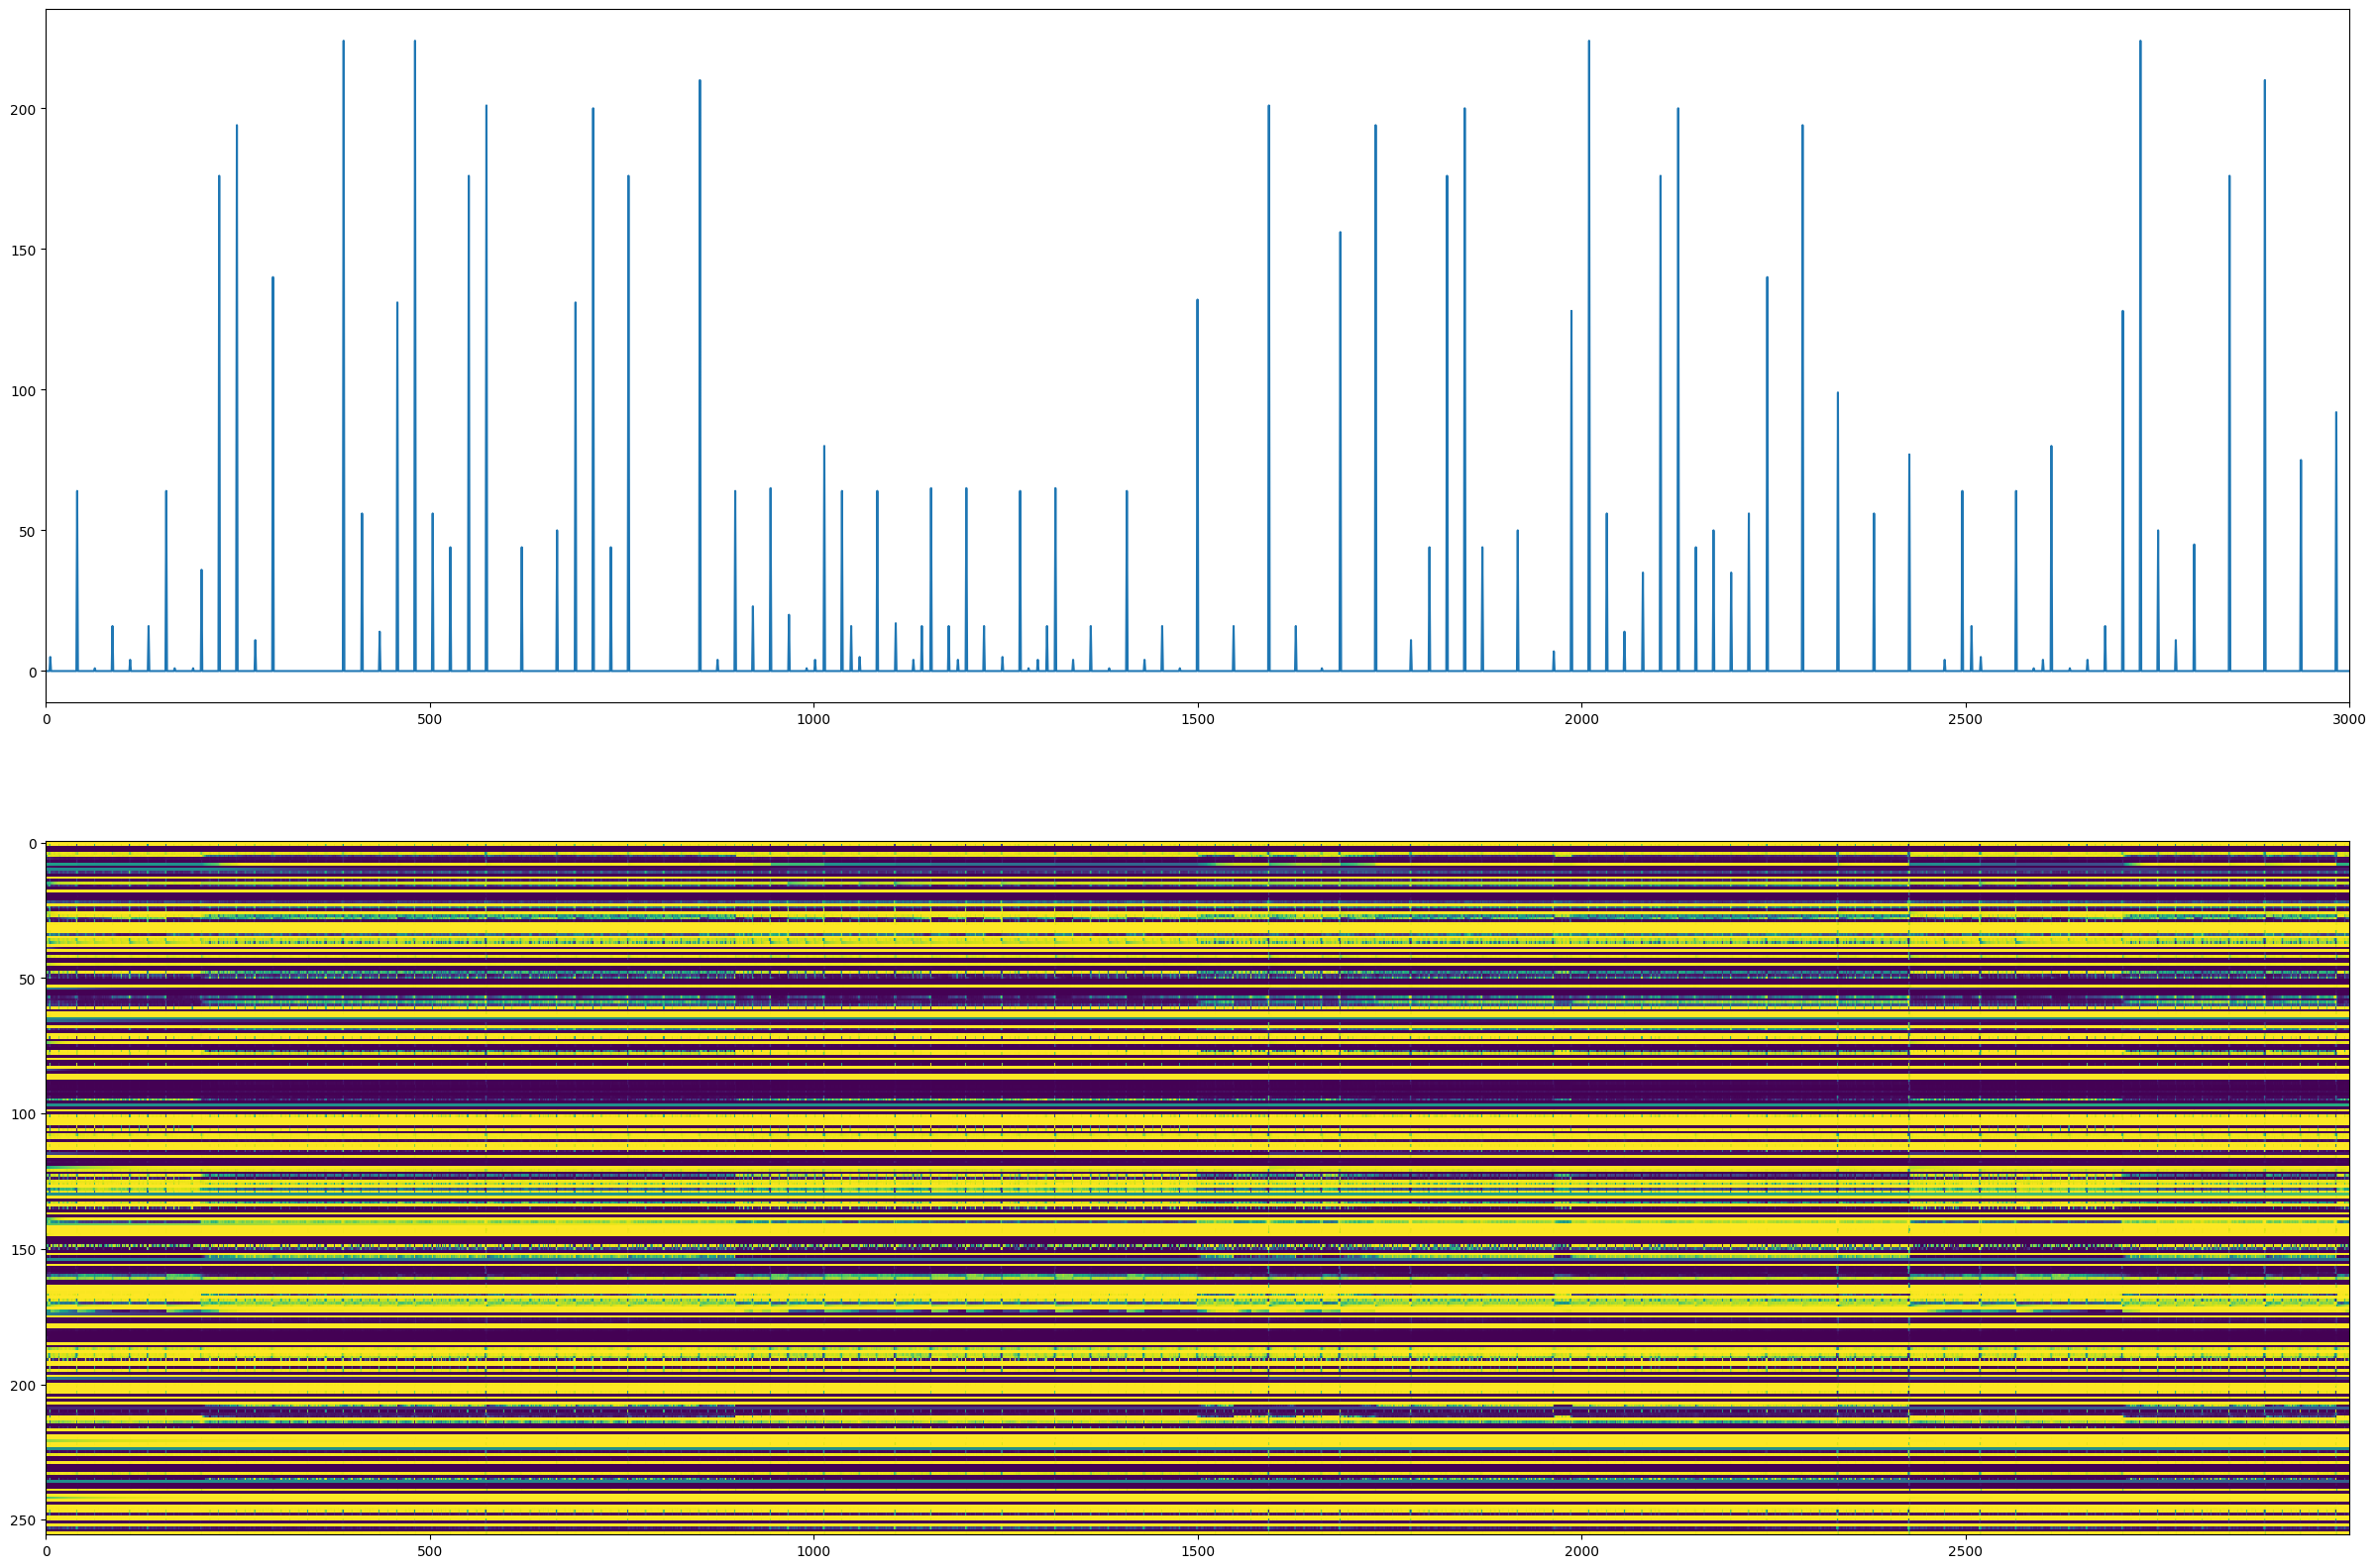

In [31]:
import matplotlib.pyplot as plt

plt.figure(figsize=(30,20))
plt.subplot(2,1,1)
plt.plot(actions[0,:-1] )
plt.xlim(0,3000)
plt.subplot(2,1,2)
plt.imshow(ns_gru_hidden.detach()[0].T, aspect='auto', interpolation='nearest')

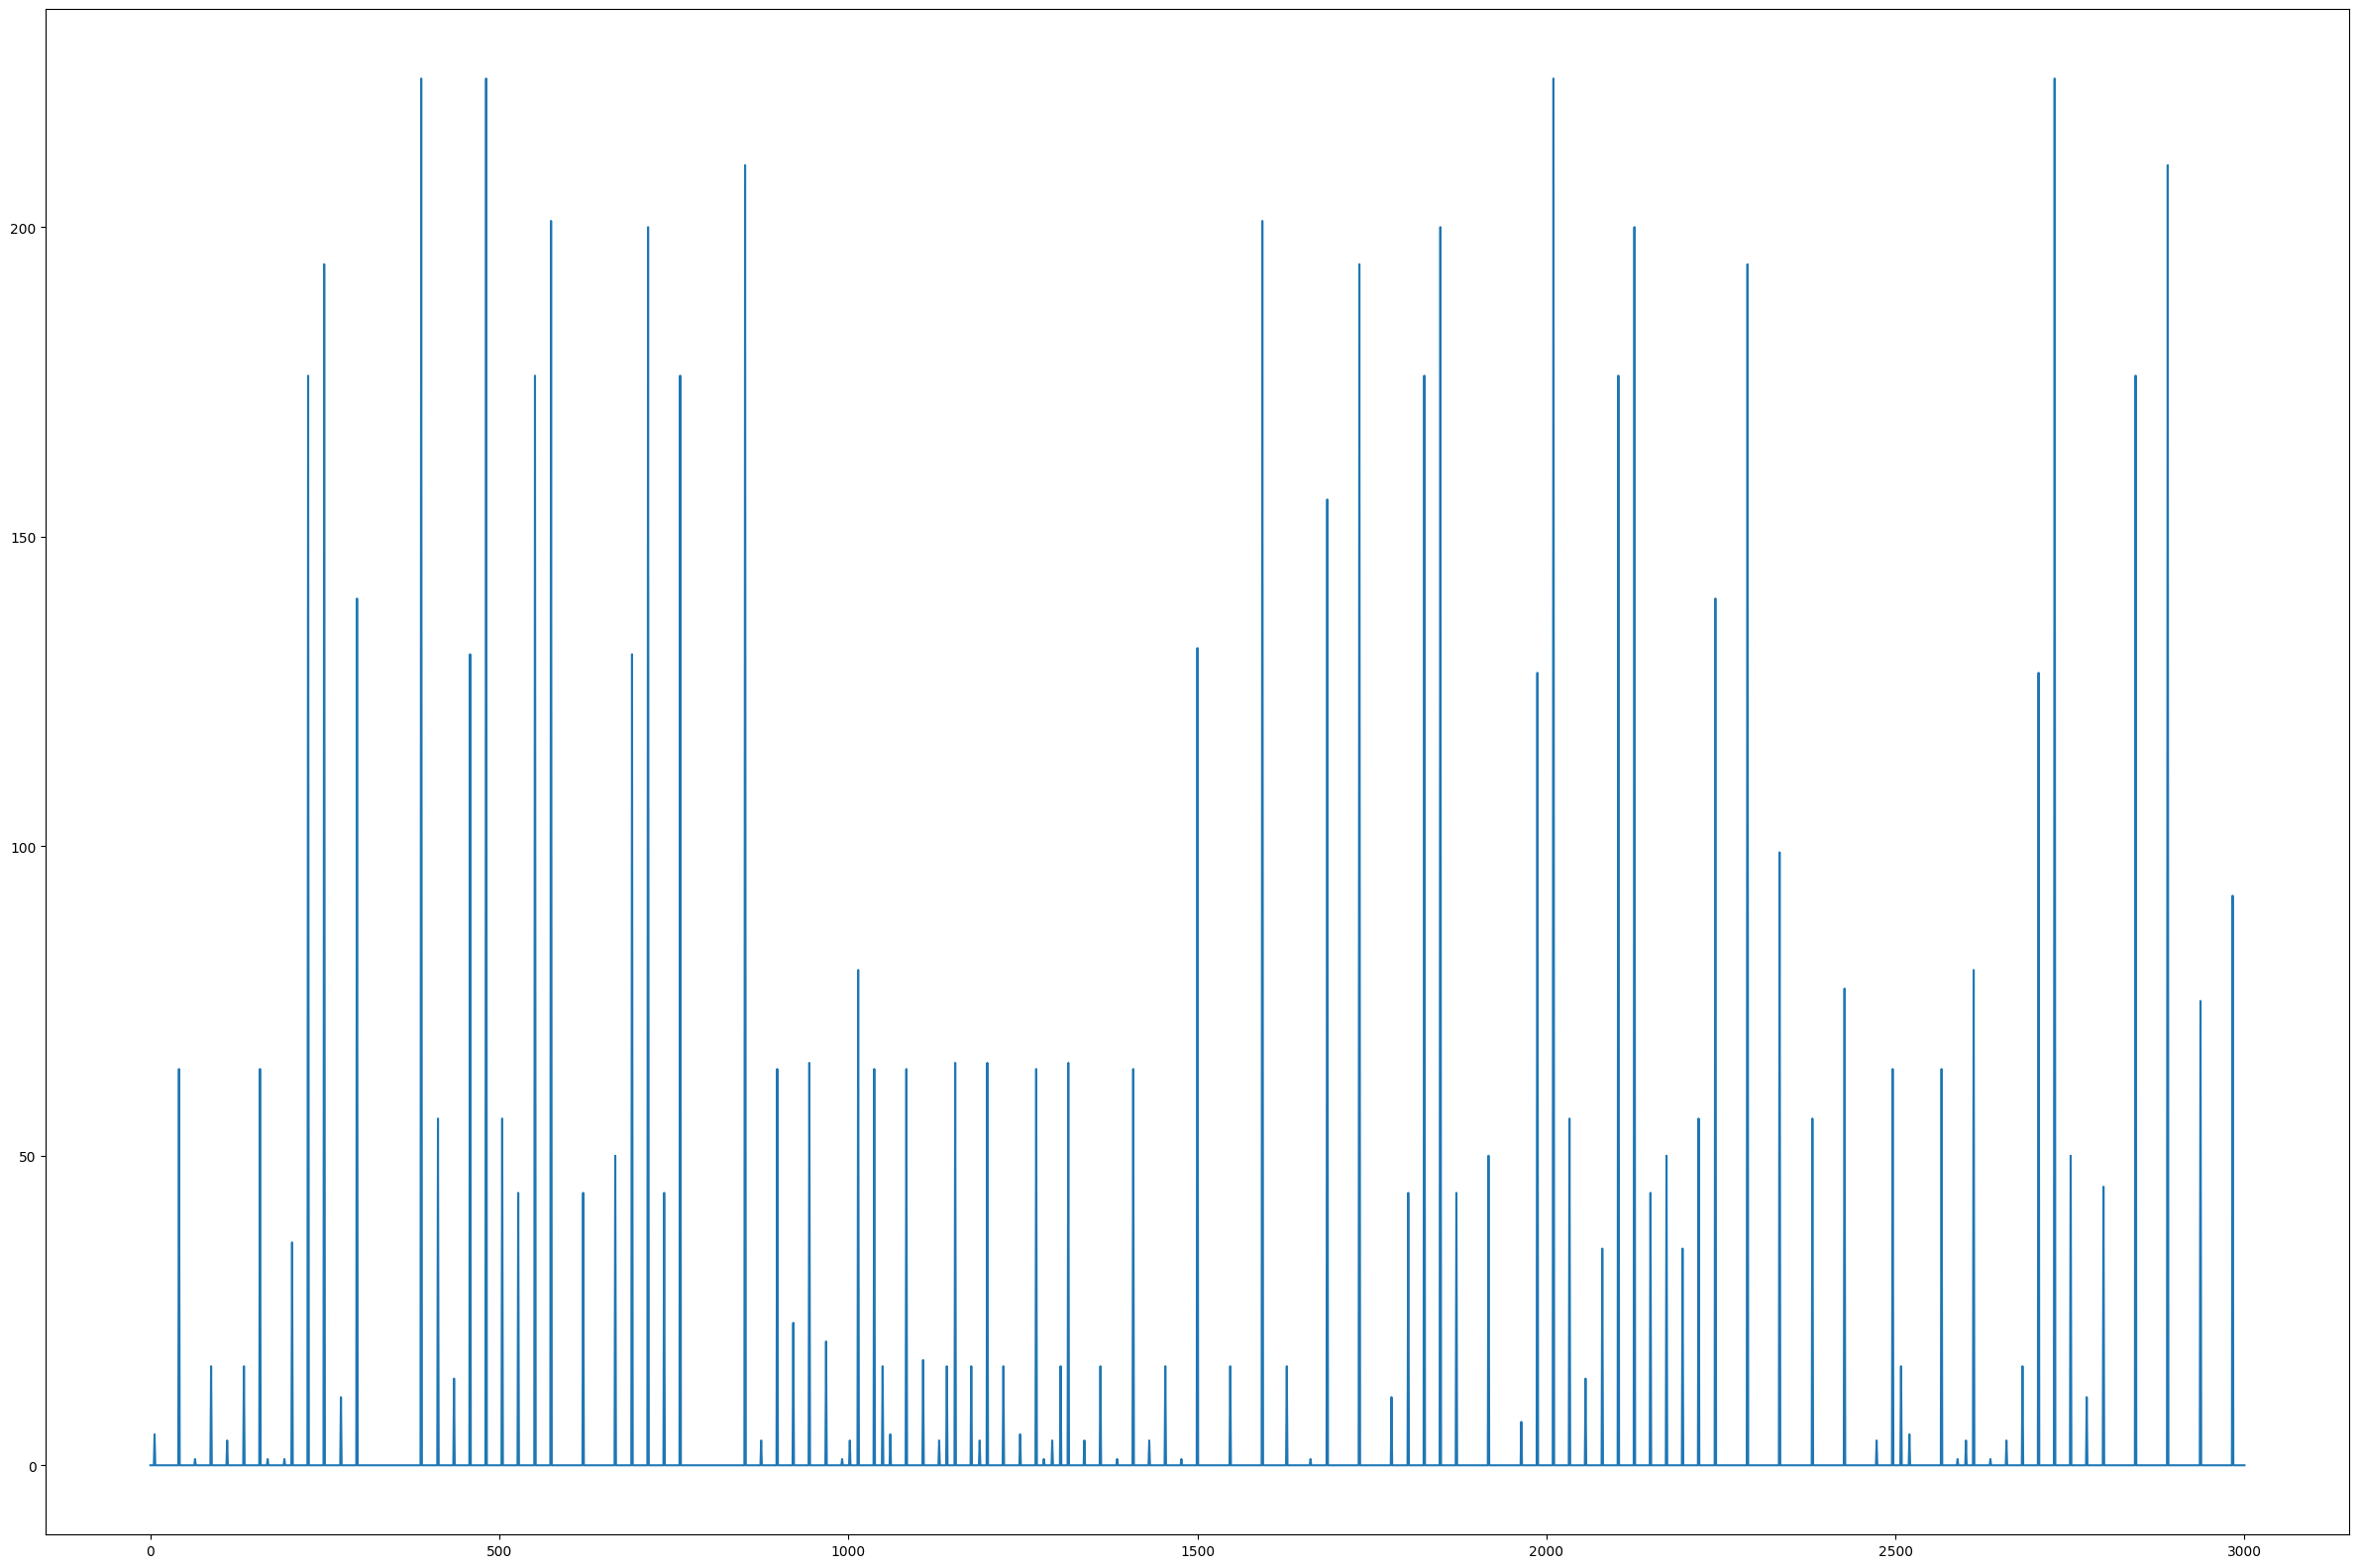

In [28]:
plt.figure(figsize=(30,20))
plt.plot(actions[0])

### Resume Training

In [ ]:
wandb.init(project='AutoOsu', id='wwjh1mq4', resume='must')
trainer.start_epoch = 40
trainer.train(60)
wandb.finish()